# TFOD Rubber Ducky Detection
### Prerequisits:
- tensorflow 2.x (with or without GPU support)
- tensorflow object detection api installed.

In [1]:
import tensorflow as tf 
print(tf.__version__)

2.5.0


In [2]:
# importing all other libraries
from object_detection.utils import label_map_util, config_util
from object_detection.utils import visualization_utils as viz_util 
from object_detection.builders import model_builder


In [3]:
import random
import  os, io 
import numpy as np
from six import BytesIO
import numpy as np 
import matplotlib 
import matplotlib.pyplot as plt
from PIL import  Image, ImageDraw, ImageFont
%matplotlib inline

# Preprocessing Image
## i. loading images and convert them to numpy arrays
`Note:` 
The main roles of the tf.io.gfile module are:
 - To provide an API that is close to Python's file I/O objects.
 - To provide an implementation based on TensorFlow's C++ FileSystem API.

In [4]:
def load_image_to_np(path):
    img_data = tf.io.gfile.GFile(path, 'rb').read()
    img = Image.open(BytesIO(img_data)).getdata()
    (width, height) = img.size 
    image_np = np.array(img).reshape((height, width, 3)).astype(np.uint8)
    return image_np


### For training, we will be using `tensorflow\object_detection`'s `test_images`

In [5]:
train_image_dir = 'C:\\Users\\User\\DL\\models\\research\\object_detection\\test_images\\ducky\\train'
train_images_np = []
for i in range(1, 6):
    path = f'{train_image_dir}\\robertducky{i}.jpg'
    train_image = os.path.join(path)
    train_images_np.append(load_image_to_np(train_image))

## ii. Visualizing Images.
`Note:`
- try plt.rcparams() for more info

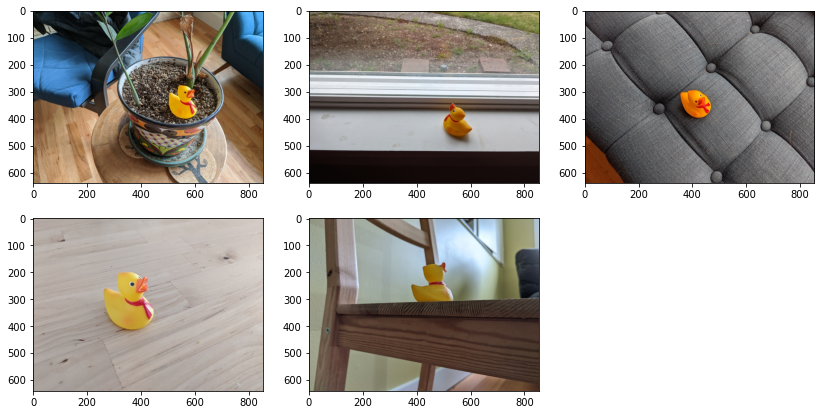

In [6]:
row, column = 2, 3 
plt.rcParams['figure.figsize'] = [14,7]
for i, train_image_np in enumerate(train_images_np):
    plt.subplot(row, column, i+1)
    plt.imshow(train_image_np)
plt.show()


## iii. Annotate the images with bounding box 

In [7]:
gt_boxes = [
            np.array([[0.436, 0.591, 0.629, 0.712]], dtype=np.float32),
            np.array([[0.539, 0.583, 0.73, 0.71]], dtype=np.float32),
            np.array([[0.464, 0.414, 0.626, 0.548]], dtype=np.float32),
            np.array([[0.313, 0.308, 0.648, 0.526]], dtype=np.float32),
            np.array([[0.256, 0.444, 0.484, 0.629]], dtype=np.float32)
]

## iv. Prepare Data for training

### 1. Converting numpy image to image tensors : 
- converts the numpy image_data to tensor
- adding an outer batch axis by passing axis=0
- appending to the train_images_tensors list
### 2. GT box preparing : 
- converts the numpy gt_box to tensor
- then appends to the list 
### 3. One hot encoding of gt classes
 - converting gt_box_classes to one-hot enocoded
 - By convention, our non-background classes start counting at 1. Given that we will be predicting just one class, we will therefore assign it a `class id` of 1. 
 - Convert class labels to one-hot; convert everything to tensors. 
 - The `label_id_offset` here shifts all classes by a certain number of indices;

`N.B` : we do this here so that the model receives one-hot labels where non-background classes start counting at the zeroth index. This is ordinarily just handled automatically in our training binaries, but we need to reproduce it here.
        
 


In [8]:
duck_class_id = 1
num_classes = 1
label_id_offset = 1

train_image_tensors = []
gt_box_tensors = []
gt_classes_one_hot_tensors = []

for (train_image_np, gt_box_np) in zip(train_images_np, gt_boxes):
    # converting image data to tensors
    train_image_tensor = tf.convert_to_tensor(train_image_np, dtype=tf.float32)
    expanded_train_image_tensor = tf.expand_dims(train_image_tensor, axis=0)
    train_image_tensors.append(expanded_train_image_tensor)
    # converting gt_boxes to tensors
    gt_box_tensor = tf.convert_to_tensor(gt_box_np, dtype=tf.float32)
    gt_box_tensors.append(gt_box_tensor)
    # converting gt_box_classes to one-hot enocoded 
    ones = np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32)
    zero_idx_gt_classes = tf.convert_to_tensor(ones - label_id_offset)
    one_hot_zero_idx_gt_classes = tf.one_hot(zero_idx_gt_classes, num_classes)
    gt_classes_one_hot_tensors.append(one_hot_zero_idx_gt_classes)

## v. Helper function to Plot the duck images with bounding(ground truth) boxes.

In [9]:
def plot_detections(image_np, boxes, classes, scores, category_index, image_name=None):
   viz_util.visualize_boxes_and_labels_on_image_array(image_np,boxes=boxes, classes=classes, scores=scores, category_index=category_index,use_normalized_coordinates=True, min_score_thresh=0.8)
   if image_name:
       plt.imsave(image_name, image_np)
   else:
       plt.imshow(image_np)


## vi. Visualizing Image with bounding Boxes

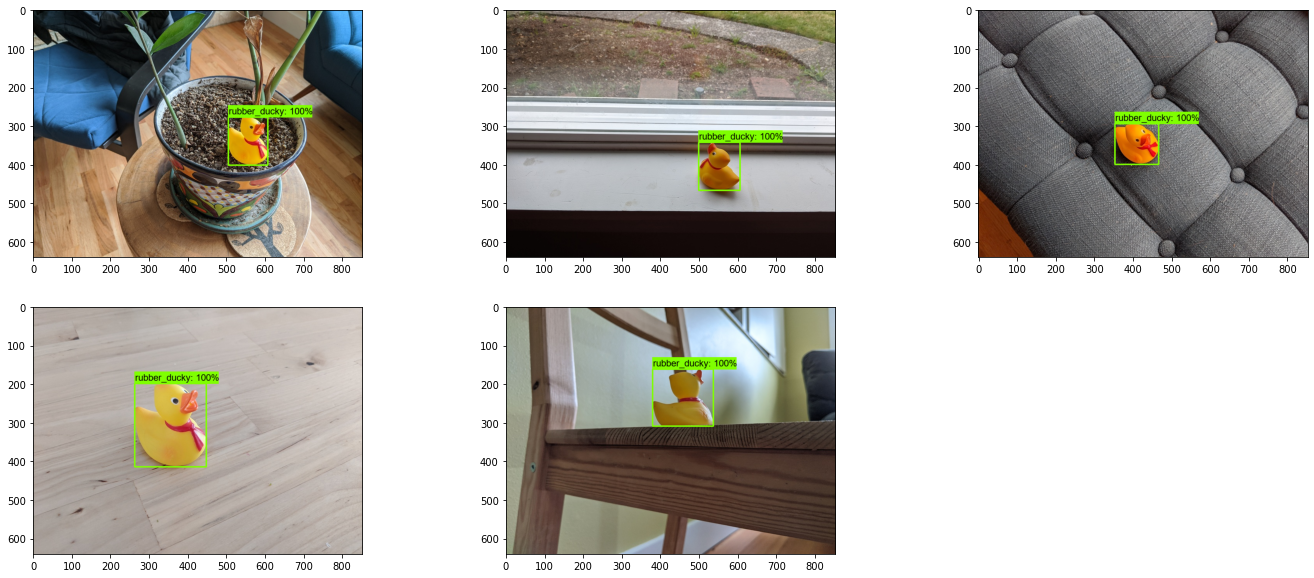

In [10]:
duck_class_id = 1
classes = np.ones(shape=gt_boxes[i].shape[0], dtype=np.int32)
category_index = {duck_class_id : {'id':duck_class_id, 'name':'rubber_ducky'}}
dummy_scores = np.array([1.0], dtype=np.float32)
row, column = 2, 3

plt.figure(figsize=(24,10))
for i in range(5):
    plt.subplot(row, column, i+1)
    plot_detections(image_np=train_images_np[i], boxes=gt_boxes[i], classes=classes, scores=dummy_scores, category_index=category_index, )

# Create model and restore weights for all but last layer.
## i. Creating the detection model from the Pipeline Config file

In [11]:
pipeline_config_path = "C:\\Users\\User\\NerdStuff\\TFOD\\models\\research\\object_detection\\configs\\tf2\\ssd_mobilenet_v1_fpn_640x640_coco17_tpu-8.config"
configs = config_util.get_configs_from_pipeline_file(pipeline_config_path)
model_configs = configs['model']
model_configs.ssd.num_classes = 1
model_configs.ssd.freeze_batchnorm = True

detection_model = model_builder.build(model_config=model_configs, is_training=True)

## ii. Restoring the weights from checkpoint

First we can see what are all the attributes of the detection model.

In [12]:
detection_model.__dict__.keys()

dict_keys(['_self_setattr_tracking', '_obj_reference_counts_dict', '_num_classes', '_self_unconditional_checkpoint_dependencies', '_self_unconditional_dependency_names', '_self_unconditional_deferred_dependencies', '_self_update_uid', '_self_name_based_restores', '_self_saveable_object_factories', '_self_tracked_trackables', '_groundtruth_lists', '_instrumented_keras_api', '_instrumented_keras_layer_class', '_instrumented_keras_model_class', '_trainable', '_stateful', 'built', '_input_spec', '_build_input_shape', '_saved_model_inputs_spec', '_supports_masking', '_name', '_activity_regularizer', '_trainable_weights', '_non_trainable_weights', '_updates', '_thread_local', '_callable_losses', '_losses', '_metrics', '_metrics_lock', '_dtype_policy', '_compute_dtype_object', '_autocast', '_inbound_nodes_value', '_outbound_nodes_value', '_expects_training_arg', '_default_training_arg', '_expects_mask_arg', '_dynamic', '_initial_weights', '_auto_track_sub_layers', '_preserve_input_structure_i

In [13]:
checkpoint_path =  "C:\\Users\\User\\NerdStuff\\TFOD\\models\\research\\object_detection\\test_data\\checkpoints\\ckpt-0"

base_tower_layer_for_heads = detection_model._box_predictor._base_tower_layers_for_heads
box_prediction_head = detection_model._box_predictor._box_prediction_head
feature_extractor = detection_model.feature_extractor

fake_box_predictor = tf.train.Checkpoint(_base_tower_layers_for_heads=base_tower_layer_for_heads, _box_prediction_head=box_prediction_head)
fake_model = tf.train.Checkpoint(_feature_extractor=feature_extractor, _box_predictor=fake_box_predictor)
checkpoint = tf.train.Checkpoint(model=fake_model)
checkpoint.restore(checkpoint_path).expect_partial()

## iii. Run model through a dummy image so that variables are created

In [14]:
images, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(images, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print("Checkpoint Restored")

Checkpoint Restored


# Eager mode custom training loop



In [15]:
trainable_variables = detection_model.trainable_variables
prefixes = ['WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead', 'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
to_fine_tune = []
for var in trainable_variables:
    for prefix in prefixes:
        if any([var.name.startswith(prefix)]):
            to_fine_tune.append(var)

In [16]:
def get_model_train_step_fun(model, optimizer, vars_to_fine_tune):
    @tf.function
    def train_step_fun(image_tensors, gt_box_list, gt_class_list):
        shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.float32)
        model.provide_groundtruth(groundtruth_boxes_list=gt_box_list, groundtruth_classes_list=gt_class_list)
        with tf.GradientTape() as tape:
            preprocessed_img = tf.concat([detection_model.preprocess(image_tensor)[0] for image_tensor in image_tensors], axis=0)
            prediction_dict = model.predict(preprocessed_img, shapes)
            losses_dict = model.loss(prediction_dict, shapes)
            total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
            grads = tape.gradient(total_loss, vars_to_fine_tune)
            optimizer.apply_gradients(zip(grads, vars_to_fine_tune))
        return total_loss
    return train_step_fun

In [17]:
batch_size =  2 
learning_rate = 0.01 
num_batches = 100
train_step_fun = get_model_train_step_fun(model=detection_model, optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9), vars_to_fine_tune=to_fine_tune)

print(f'Training Starts')
for i in range(num_batches):
    # Grab keys for a random subset of examples
    all_keys = list(range(len(train_images_np)))
    random.shuffle(all_keys)
    example_keys = all_keys[:batch_size]

    image_tensors = [train_image_tensors[key] for key in example_keys]
    gt_box_list = [gt_box_tensors[key] for key in example_keys]
    gt_class_list = [gt_classes_one_hot_tensors[key] for key in example_keys]

    # training step ( Forward & Backward Pass )
    total_loss = train_step_fun(image_tensors, gt_box_list, gt_class_list)

    if i%10 == 0: 
        print(f'batch {i} of {num_batches}, loss={total_loss.numpy()}')
print('Done fine-tuning!')



Training Starts
batch 0 of 100, loss=1.1955188512802124
batch 10 of 100, loss=0.08038534969091415
batch 20 of 100, loss=0.04806409403681755
batch 30 of 100, loss=0.04880423843860626
batch 40 of 100, loss=0.023952795192599297
batch 50 of 100, loss=0.016322214156389236
batch 60 of 100, loss=0.009813529439270496
batch 70 of 100, loss=0.013011027127504349
batch 80 of 100, loss=0.011150886304676533
batch 90 of 100, loss=0.012567059136927128
Done fine-tuning!


# Load test images and run inference with new model!

### i. Test Image Preprocessing

In [31]:
test_image_dir ='C:\\Users\\User\\DL\\models\\research\\object_detection\\test_images\\ducky\\test'
test_images_np = []
for i in range(1, 50):
    path = os.path.join(f'{test_image_dir}\\out{i}.jpg')
    test_image_np = load_image_to_np(path) 
    expanded_test_image_np = np.expand_dims(test_image_np, axis=0)
    test_images_np.append(expanded_test_image_np)

In [32]:
len(test_image_nps)

49

### ii. Helper function to detect test images.

In [33]:
@tf.function
def detect(input_tensor):
    preprocessed_image, shapes = detection_model.preprocess(input_tensor)
    prediction_dict = detection_model.predict(preprocessed_image, shapes)
    return detection_model.postprocess(prediction_dict, shapes)

### iii. Start detection and visualizing!

dict_keys(['detection_boxes', 'detection_scores', 'detection_classes', 'num_detections', 'raw_detection_boxes', 'raw_detection_scores', 'detection_multiclass_scores', 'detection_anchor_indices'])

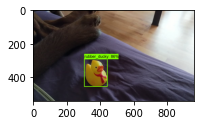

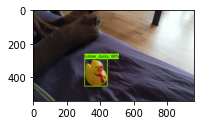

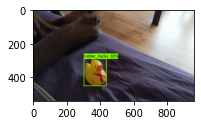

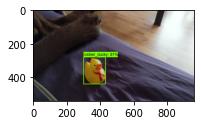

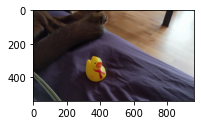

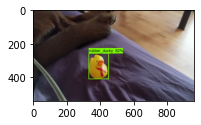

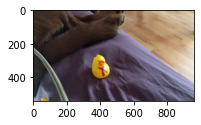

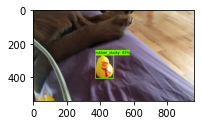

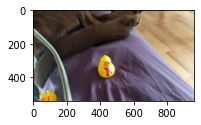

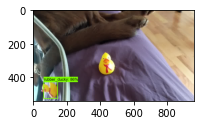

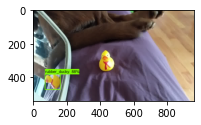

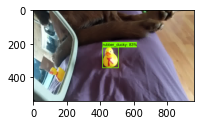

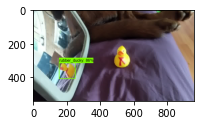

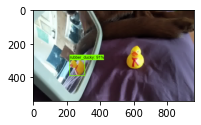

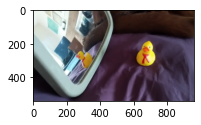

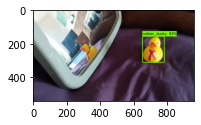

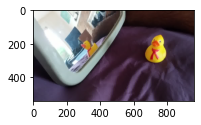

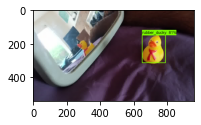

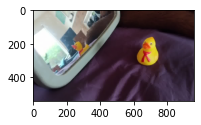

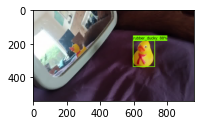

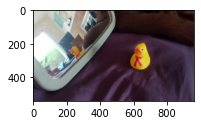

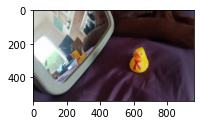

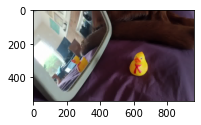

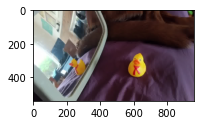

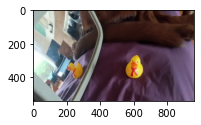

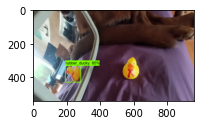

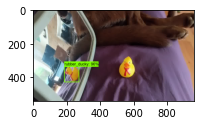

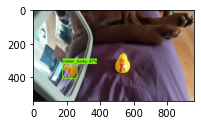

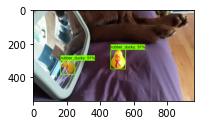

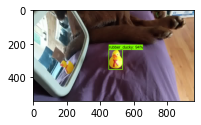

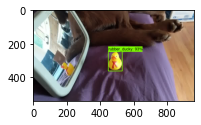

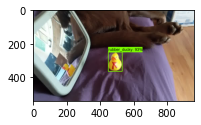

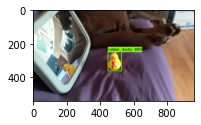

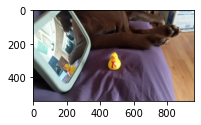

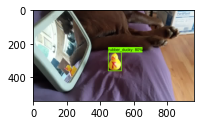

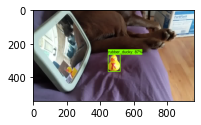

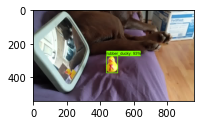

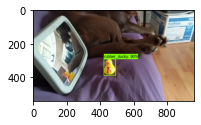

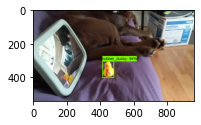

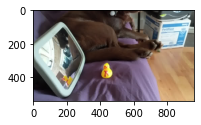

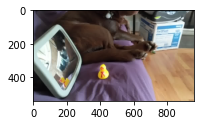

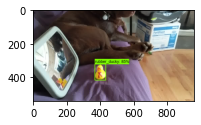

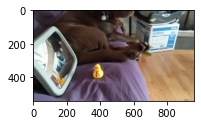

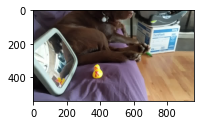

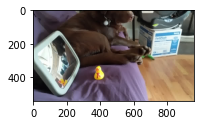

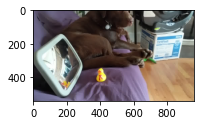

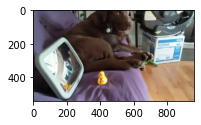

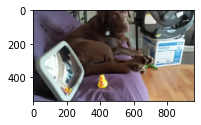

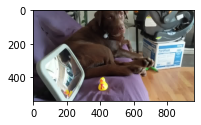

In [37]:
label_id_offset = 1
row, column = 5, 10
for i in range(len(test_images_np)):
    input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
    detections = detect(input_tensor)
    # print(detections.keys())

    plt.figure(figsize=(34,10))
    plt.subplot(row, column, i+1)
    plot_detections(
        image_np=test_image_nps[i][0], 
        boxes=detections['detection_boxes'][0].numpy(), 
        classes=detections['detection_classes'][0].numpy().astype(np.uint32) - label_id_offset, 
        scores=detections['detection_scores'][0].numpy(), 
        category_index=category_index)
    plt.show()